In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout


image 1/1 C:\Users\MRITH\Downloads\ANN_CA_3\Number-Plate-Recognition\GeoTagPics - Copy\20240826_34618PMByGPSMapCamera.jpg: 256x320 1 licence, 93.3ms
Speed: 3.0ms preprocess, 93.3ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 320)


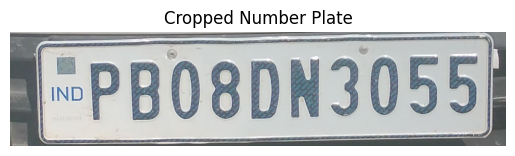

In [ ]:
def crop_number_plate(image, bbox):
    xmin, ymin, xmax, ymax = bbox
    cropped_image = image[ymin:ymax, xmin:xmax]
    return cropped_image

model = YOLO(r'runs\detect\train\weights\best.pt')

image_path = r"image_path_to_test"
results = model.predict(image_path, save=False, imgsz=320, conf=0.5)
image = cv2.imread(image_path)
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy() 
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        cropped_image = crop_number_plate(image, (xmin, ymin, xmax, ymax))
        plt.figure()
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Number Plate')
        plt.axis('off')
        plt.show()


In [17]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('contour.jpg')
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [18]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

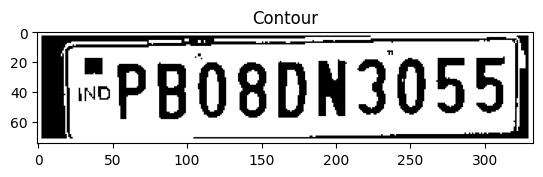

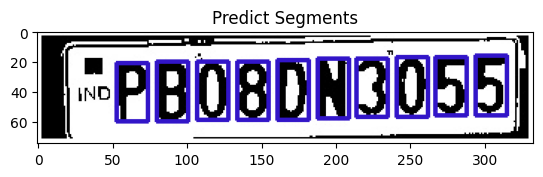

In [19]:
char=segment_characters(cropped_image)

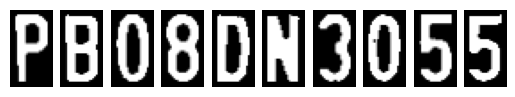

In [20]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [21]:
char_models = Sequential()
char_models.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
char_models.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
char_models.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
char_models.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
char_models.add(MaxPooling2D(pool_size=(4, 4)))
char_models.add(Dropout(0.4))
char_models.add(Flatten())
char_models.add(Dense(128, activation='relu'))
char_models.add(Dense(36, activation='softmax'))


In [ ]:
char_models.load_weights('./character_training/chars.weights.h5')

In [ ]:
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3), dtype=np.uint8)
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(char_images, loaded_model):
    dic = {i: c for i, c in enumerate('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')}
    output = []

    for img in char_images:  # iterating over the character images
        img_ = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        predictions = char_models.predict(img)  # predicting the class
        y_ = np.argmax(predictions)  # get the index of the max probability
        character = dic[y_]
        output.append(character)  # storing the result in a list
        
    plate_number = ''.join(output)
    return plate_number

a=show_results(char, char_models)
print(a)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
P908DH3055


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

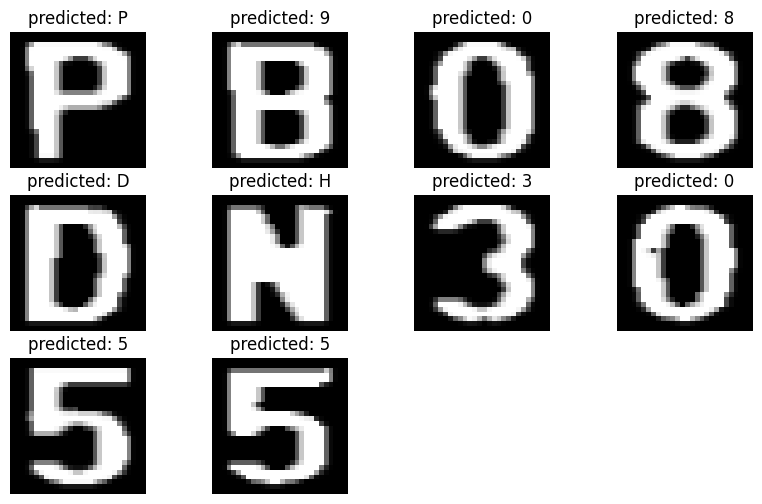

In [24]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(char,char_models)[i]}')
    plt.axis('off')
plt.show()

In [13]:
def get_exif_data(image):
    """Extract EXIF data from an image and return it as a dictionary."""
    exif_data = {}
    try:
        image = Image.open(image)
        info = image._getexif()
        if info is not None:
            for tag, value in info.items():
                tag_name = TAGS.get(tag, tag)
                exif_data[tag_name] = value
    except Exception as e:
        print(f"Error: {e}")
    return exif_data

def get_geolocation(exif_data):
    """Extract the GPS coordinates from the EXIF data."""
    gps_info = exif_data.get("GPSInfo", None)
    if not gps_info:
        return None

    gps_data = {}
    for tag, value in gps_info.items():
        tag_name = GPSTAGS.get(tag, tag)
        gps_data[tag_name] = value

    try:
        latitude = gps_data["GPSLatitude"]
        latitude_ref = gps_data["GPSLatitudeRef"]
        longitude = gps_data["GPSLongitude"]
        longitude_ref = gps_data["GPSLongitudeRef"]

        lat = convert_to_degrees(latitude)
        if latitude_ref != "N":
            lat = -lat

        lon = convert_to_degrees(longitude)
        if longitude_ref != "E":
            lon = -lon

        return lat, lon
    except KeyError:
        return None

def convert_to_degrees(value):
    """Convert GPS coordinates from EXIF format to degrees."""
    d, m, s = value
    return d + (m / 60.0) + (s / 3600.0)

exif_data = get_exif_data(image_path)
geolocation = get_geolocation(exif_data)

if geolocation:
    print(f"Latitude: {geolocation[0]}, Longitude: {geolocation[1]}")
else:
    print("No GPS data found.")


No GPS data found.


Storing Data in Excel

In [12]:
new_data = {
    'Latitude': [geolocation[0]],
    'Longitude': [geolocation[1]],
    'number plate': [a]
}

new_df = pd.DataFrame(new_data)
file_path = 'number_plate_data.xlsx'

try:
    existing_df = pd.read_excel(file_path, index_col=0)
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)
except FileNotFoundError:
    updated_df = new_df

updated_df.to_excel(file_path, index=True)
print("Successfully Updates!")


Successfully Updates!
